# Setup

In [97]:
import os
import scipy
import random
import datetime
import importlib
import numpy as np
import scipy.sparse.linalg
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Callable, List, Union

from matrixlib import preconditioning as prec
from matrixlib.core import MatrixData, ValueProperties, BlockProperties
from matrixlib.plot import plot_matrices_and_metadata
#import CNN
import CNN.models
import CNN.training
import CNN.evaluation

# Check wd
current_base_path = os.getcwd()
print(f"Path to current working directory: {current_base_path}")
!whoami

Path to current working directory: /home/moonchild/PycharmProjects/opencampus-preconditioner-ai-project
moonchild


In [ ]:
# !pip install tensorflow-gpu==2.3.0

In [ ]:
# !pip install tensorflow[and-cuda]

In [ ]:
# %%capture
# !pip install numpy==1.23.1 Pillow==9.2.0 importlib-metadata==4.11.3 matplotlib==3.5.2 scikit-learn==1.1.1 tensorboard==2.9.1 jupyter==1.0.0 ipykernel==6.9.1 seaborn==0.13.2

In [30]:
# import sys
# import os
# 
# # Add the project directory to the Python path
# sys.path.append('/home/azureuser/projects/opencampus-preconditioner-ai-project')
# 
# # Change the working directory to the project directory
# os.chdir('/home/azureuser/projects/opencampus-preconditioner-ai-project')
# print(os.getcwd())  # Verify the change

In [31]:
tf.config.list_physical_devices('GPU') 

[]

# Generate Synthetic Data
Generate a set of `n` square symmetrical and positive semi matrices of dimensions `MATRIX_DIM` to RAM.

## Define Constants
The following constants are used throughout the rest of the notebook.

In [32]:
MATRIX_DIM = 64
NUMBER_OF_MATRICES = 100
DIAGONAL_BAND_RADIUS = 10
RNG_SEED = 42
VALUE_COLORBAR = 'rocket'
BLOCK_COLORBAR = 'flare'

initialized        data vectors of size    100 x  64 x  64 =    409600 with a memory usage of   1.562 MiB
initialized  data start vectors of size    100 x  64       =      6400 with a memory usage of   0.006 MiB
initialized noise start vectors of size    100 x  64       =      6400 with a memory usage of   0.006 MiB
initialized        band vectors of size    100 x  64 x  10 =     64000 with a memory usage of   0.513 MiB
--------------------------------------------------------------------------------
instantiation rng generators...
generating matrices...
invalid matrices: 0
determinant abs-value range: [0.09879070520401001, 1241520.875]


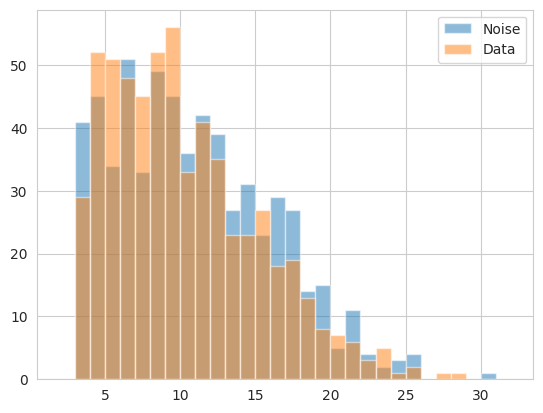

duration: 7.43 seconds


In [12]:
    # Generate matrices
bgr_noise_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.0, 0.5))
noise_blk_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.3, 1.0))
noise_blk_block_props = BlockProperties(size_range=(3, 32), size_average=10, size_std_dev=0.66, gap_chance=0.5)
tdata_blk_value_props = ValueProperties(density_range=(0.5, 0.7), value_range=(0.3, 1.0))
tdata_blk_block_props = BlockProperties(size_range=(2, 32), size_average=10, size_std_dev=0.66, gap_chance=0)

test_data = MatrixData(
        dimension=MATRIX_DIM,
        band_radius=DIAGONAL_BAND_RADIUS,
        sample_size=NUMBER_OF_MATRICES,
        background_noise_value_properties=bgr_noise_value_props,
        block_noise_value_properties=noise_blk_value_props,
        block_noise_block_properties=noise_blk_block_props,
        block_data_value_properties=tdata_blk_value_props,
        block_data_block_properties=tdata_blk_block_props,
        seed=42,
        determinant_cutoff=0.01,
        print_debug=True
    )

In [8]:
test_data.tdata_blk_starts[0]
# test_data.bands.shape


array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int8)

In [13]:
bands = test_data.bands.reshape(NUMBER_OF_MATRICES, (DIAGONAL_BAND_RADIUS* 2 + 1), MATRIX_DIM, 1)
bands = np.nan_to_num(bands) # replace NaNs with 0s
labels = test_data.tdata_blk_starts
print(bands.shape, labels.shape)

# Create dataset from matrices and labels
dataset = tf.data.Dataset.from_tensor_slices((bands, labels))

# Split the dataset
train_size = int(0.8 * NUMBER_OF_MATRICES)
val_size = int(0.1 * NUMBER_OF_MATRICES)
test_size = NUMBER_OF_MATRICES - train_size - val_size

train_dataset = dataset.take(train_size).shuffle(buffer_size=10)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")


(100, 21, 64, 1) (100, 64)
Train size: 80, Val size: 10, Test size: 10


In [14]:
# Verfiy Shape
print(train_dataset)
print(val_dataset)
print(test_dataset)

# for element in val_dataset:
#    print(element)

<_ShuffleDataset element_spec=(TensorSpec(shape=(21, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int8, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(21, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int8, name=None))>
<_SkipDataset element_spec=(TensorSpec(shape=(21, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int8, name=None))>


# Training
run tensorboard --logdir logs to launch tensorboard

In [15]:
importlib.reload(CNN.training)
importlib.reload(CNN.models)

# Define parameters
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
num_epochs = 10

# Create log dir
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
print("Files in log directory:", os.listdir(log_dir))

def set_seeds(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seeds()

# Compile Model
model = CNN.models.Baseline(input_shape=((DIAGONAL_BAND_RADIUS * 2 + 1), MATRIX_DIM, 1))
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

Files in log directory: []


In [16]:
# Start Training Loop
trained_model, train_losses, val_losses = CNN.training.train_model(
    model=model,
    train_dataset=train_dataset.batch(1),  # Adjust when connected to vm
    val_dataset=val_dataset.batch(1),
    loss_fn=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    log_dir=log_dir
)

Epoch 1/10


2024-06-22 10:52:18.354279: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2024-06-22 10:52:18.370399: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2024-06-22 10:52:18.377680: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2024-06-22 10:52:18.858202: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2024-06-22 10:52:18.904739: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24084480 exceeds 10% of free system memory.
2024-06-22 10:52:52.467443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-22 10:52:53.970053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting wi

Train Loss: 0.6757 | Validation Loss: 0.5994
Epoch 2/10


2024-06-22 10:53:30.592831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-22 10:53:31.072823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.4723 | Validation Loss: 0.3980
Epoch 3/10


2024-06-22 10:53:58.780652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-22 10:53:59.111592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.3679 | Validation Loss: 0.3307
Epoch 4/10


2024-06-22 10:54:24.326471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-22 10:54:24.684464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.3373 | Validation Loss: 0.3064
Epoch 5/10


2024-06-22 10:54:49.228463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-22 10:54:49.566019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.3203 | Validation Loss: 0.2935
Epoch 6/10


2024-06-22 10:55:25.733799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-22 10:55:26.205178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.3101 | Validation Loss: 0.2867
Epoch 7/10


2024-06-22 10:55:53.958707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-22 10:55:54.305790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.3026 | Validation Loss: 0.2809
Epoch 8/10


2024-06-22 10:56:22.089136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-22 10:56:22.543780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.2965 | Validation Loss: 0.2771
Epoch 9/10


2024-06-22 10:56:49.123041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-22 10:56:49.515261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.2919 | Validation Loss: 0.2739
Epoch 10/10


2024-06-22 10:57:18.211189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-22 10:57:18.641683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.2877 | Validation Loss: 0.2716
Restoring model weights from the end of the best epoch: 10.
Model weights after training:
[array([0.9981774], dtype=float32), array([-0.00212236], dtype=float32), array([0.32974973], dtype=float32), array([0.10691744], dtype=float32), array([[[[ 0.06033942,  0.02889812, -0.02534689,  0.07740587,
          -0.07271679,  0.02509671,  0.0791579 , -0.05723776,
           0.00342804,  0.02192936, -0.07147552, -0.00986171,
           0.08037023, -0.00466539,  0.00026546,  0.0452269 ,
          -0.08247521, -0.05198558,  0.00169278, -0.07414801,
          -0.0798487 ,  0.05855597,  0.07058918, -0.0415628 ,
           0.06129351, -0.06491436, -0.00763502,  0.0118001 ,
           0.01075682, -0.05146426, -0.04858812,  0.08330593]],

        [[-0.06714199, -0.0083998 , -0.04131676, -0.06361511,
           0.03962619, -0.05503548,  0.0303805 ,  0.02502492,
          -0.07782435,  0.01082656, -0.02845378, -0.02015461,
           0.07824737, -0.01522541,

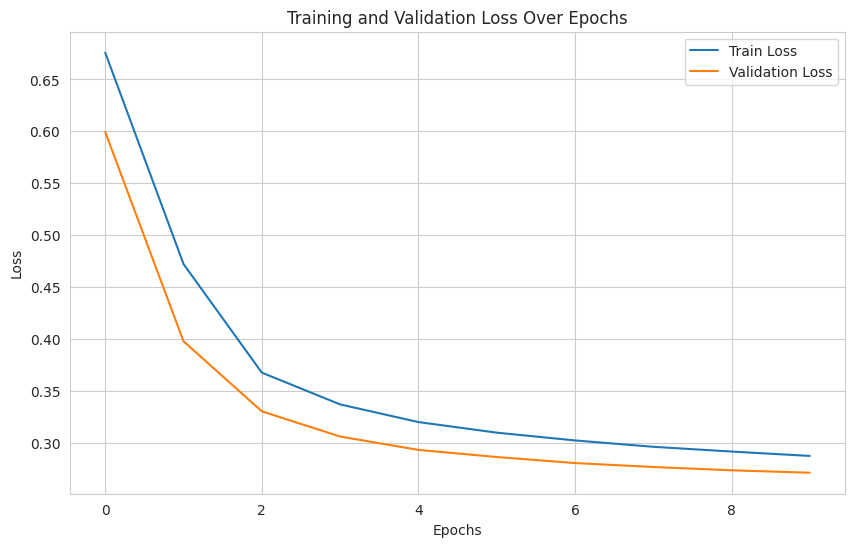

In [20]:
# Plot losses
def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation losses.

    Args:
        train_losses (list of float): List of training losses per epoch.
        val_losses (list of float): List of validation losses per epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)

# Evaluation

In [21]:
# Evaluate the model on the test set
evaluation_results = CNN.evaluation.evaluate_model(
    model=trained_model,
    test_dataset=test_dataset.batch(1),
    loss_fn=loss_fn
)

2024-06-22 10:57:30.466657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


True Labels Shape: (640,)
Predicted Labels Shape: (640,)
Test Loss: 0.3050
Accuracy: 0.9109
Precision: 0.9190
Recall: 0.9109
F1 Score: 0.8801


In [19]:
import h5py
# Restore weights from best run
new_model = CNN.models.Baseline(input_shape=((DIAGONAL_BAND_RADIUS * 2 + 1), MATRIX_DIM, 1))
new_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# best_checkpoint_file = os.path.join(log_dir, "baseline_final.weights.h5")  
new_model.load_weights("/home/moonchild/PycharmProjects/opencampus-preconditioner-ai-project/logs/fit/20240620-160632/model.10-0.3015.weights.h5")

# Log model weights after loading
print("Model weights after loading:")
print(new_model.get_weights())

# Evaluate the restored model
new_results = CNN.evaluation.evaluate_model(
    model=new_model,
    test_dataset=test_dataset.batch(1),
    loss_fn=loss_fn
)

Model weights after loading:
[]
True Labels Shape: (640,)
Predicted Labels Shape: (640,)
Test Loss: 0.7100
Accuracy: 0.5453
Precision: 0.7999
Recall: 0.5453
F1 Score: 0.6333


2024-06-22 10:57:23.624660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Prediction

In [70]:
# Extract test matrices and labels from dataset
test_bands = bands[train_size + val_size:]
print(f"labels[0] = {labels[train_size + val_size]}")
test_labels = labels[train_size + val_size:]
print(f"test_labels[0] = {test_labels[0]}")
# Make Predictions
test_predictions = trained_model.predict(test_dataset.batch(2))

# Convert to Binary
threshold = 0.5
binary_predictions = (test_predictions >= threshold).astype(int)

# Calculate Metrics
overall_accuracy = (binary_predictions == test_labels).mean()
print("Overall Accuracy:")
print(overall_accuracy)

labels[0] = [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
test_labels[0] = [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Overall Accuracy:
0.9109375


In [24]:
test_matrices = test_data.matrices[train_size + val_size:]
print(test_matrices.shape)
print(test_bands.shape)
print(binary_predictions.shape)

for i in range(min(5, test_matrices.shape[0])):
    print(f"Condition number of matrix {i}: {np.linalg.cond(test_matrices[i])}")

(10, 64, 64)
(10, 21, 64, 1)
(10, 64)
Condition number of matrix 0: 498.46612548828125
Condition number of matrix 1: 160.27406311035156
Condition number of matrix 2: 2381.751708984375
Condition number of matrix 3: 2247.297607421875
Condition number of matrix 4: 688.6673583984375



# Create Preconditioner from predicted block starts
### 1. Form Blocks from Predictions
### 2. Invert Blocks (ensure non-singularity)
### 3. Create Block Diagonal Matrix



# Run GMRES Solver with and without Precodnitioner

In [ ]:
# Define inputs
A = test_matrices
precs = prec.block_jacobi_preconditioner_from_predictions(A, test_labels)
b = np.ones((A.shape[0], A.shape[1]))

In [100]:
# reload
importlib.reload(prec)

# Solve without preconditioner
x_no_prec, info_no_prec, iters_no_prec, residuals_no_prec = prec.solve_with_gmres_monitored(A, b)

# Solve with block Jacobi preconditioner
x_prec, info_prec, iters_prec, residuals_prec = prec.solve_with_gmres_monitored(A, b, M=precs)

# Calculate and print the relative residuals
rel_residuals_no_prec = [np.linalg.norm(b[i] - A[i] @ x_no_prec[i]) / np.linalg.norm(b[i]) for i in range(A.shape[0])]
rel_residuals_prec = [np.linalg.norm(b[i] - A[i] @ x_prec[i]) / np.linalg.norm(b[i]) for i in range(A.shape[0])]

print("\nRelative residual:")
print(f"  Without preconditioner: min={np.min(rel_residuals_no_prec):.2e}, max={np.max(rel_residuals_no_prec):.2e}, mean={np.mean(rel_residuals_no_prec):.2e}")
print(f"  With preconditioner: min={np.min(rel_residuals_prec):.2e}, max={np.max(rel_residuals_prec):.2e}, mean={np.mean(rel_residuals_prec):.2e}")

Without preconditioner:
  Converged: 10 out of 10
  Average iterations: 379.00
With preconditioner:
  Converged: 9 out of 10
  Average iterations: 2000.00

Relative residual:
  Without preconditioner: min=9.99e-04, max=1.00e+00, mean=9.00e-01
  With preconditioner: min=2.26e-02, max=1.00e+00, mean=9.02e-01


TypeError: 'Axes' object is not subscriptable

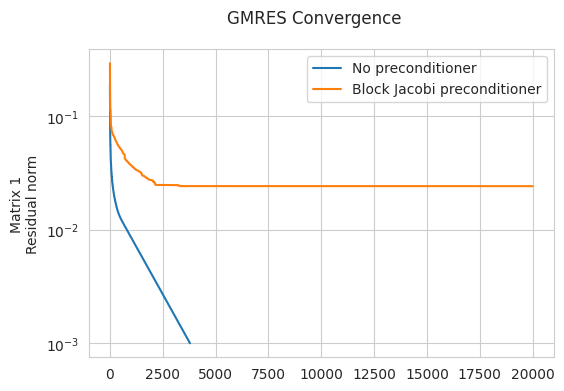

In [101]:
# Plot convergence for a few matrices
num_plots = min(1, A.shape[0])
fig, axes = plt.subplots(num_plots, 1, figsize=(6, 4*num_plots), sharex=True)
fig.suptitle('GMRES Convergence')

for i in range(num_plots):
    ax = axes[i] if num_plots > 1 else axes
    ax.semilogy(residuals_no_prec[i], label='No preconditioner')
    ax.semilogy(residuals_prec[i], label='Block Jacobi preconditioner')
    ax.set_ylabel(f'Matrix {i+1}\nResidual norm')
    ax.legend()

axes[-1].set_xlabel('Iteration')
plt.tight_layout()
plt.show()

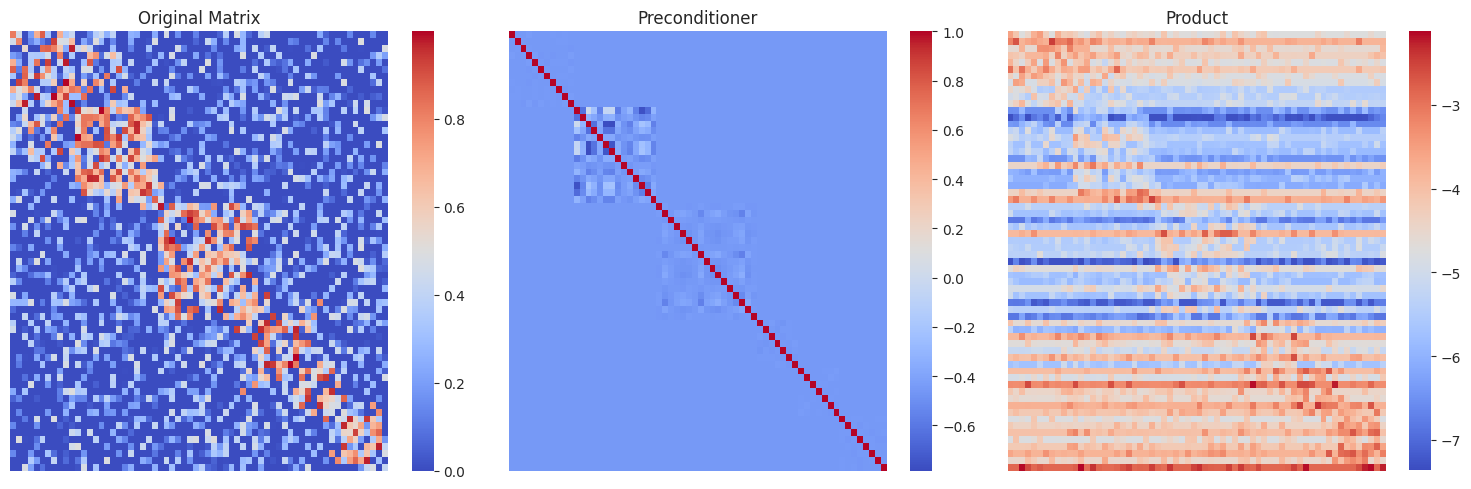

In [102]:
# Function to plot matrices
def plot_matrices(matrices: List[np.ndarray], titles: List[str], colorbar: str = VALUE_COLORBAR) -> None:
    num_matrices = len(matrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(5 * num_matrices, 5))

    for i, (matrix, title) in enumerate(zip(matrices, titles)):
        ax = axes[i] if num_matrices > 1 else axes
        sns.heatmap(matrix, cmap=colorbar, ax=ax, cbar=True)
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()
    
# Plot matrices
plot_matrices([test_matrices[0], precs[0], np.matmul(test_matrices[0], precs[0])], ['Original Matrix', 'Preconditioner', 'Product'], colorbar='coolwarm')

In [94]:
# Check condition number
from numpy.linalg import cond

print(f"Condition number original: {cond(test_matrices[0])}")
print(f"Frobenius norm of difference between preconditioner and inverse: {np.linalg.norm(precs[0] - np.linalg.inv(A[0]))}")
#residual = np.linalg.norm(b_example - A_example @ x_prec)
#print(f"Residual after preconditioned GMRES: {residual}")

Condition number original: 498.46612548828125
Frobenius norm of difference between preconditioner and inverse: 60.24431610107422
